# 💹🚀 Building a Stock Analyzer with WaterCrawl × Claude 3.7 × E2B × Tavily

Welcome to this **step-by-step Jupyter Notebook** where you'll unleash powerful financial analysis using the latest AI & scraping tools:

1. 🕷️ **WaterCrawl** – Lightning-fast, customizable web crawling for up-to-date stock info
2. 🤖 **Claude 3.7** – Expert-level financial analysis and crisp, structured insights
3. 📊 **E2B Code Interpreter** – Instantly visualize your findings, in-code!
4. 🔎 **WaterCrawl Search API** – Find just the right stock pages (so you're always using the freshest data!)

---

### What will you learn? 👨‍🎓👩‍💻

- How to set up WaterCrawl + API keys in minutes
- 🕸️ Crawl and extract financial data, zero HTML hassle
- 📈 Supercharge stock insights using Claude 3.7
- 📊 Generate pretty Python charts from your AI analysis
- 💡 Pro tips for reliable, robust data scraping and analytics

---

#### 🔑 **What do you need?**

| Service       | Key Purpose                | Where to generate                               |
|--------------|---------------------------|-------------------------------------------------|
| WaterCrawl   | Search andCrawl anything            | [Get API key](https://app.watercrawl.dev/dashboard/api-keys)     |
| Anthropic    | Power Claude 3.7          | [Get API key](https://console.anthropic.com/settings/keys)       |
| E2B          | In-notebook code & plots  | [Get API key](https://app.e2b.dev/)             |

Let's begin! 🎉

---
## 1. 🚦 Setup and Installation

> **Install all dependencies in one go!**

In [1]:
# !pip install watercrawl-py anthropic e2b-code-interpreter python-dotenv matplotlib requests

---
## 2. 📦 Import Required Libraries

> Bring in the packages you'll use for everything from crawling to charting.

In [1]:
import os
from watercrawl import WaterCrawlAPIClient
import anthropic
from e2b_code_interpreter import Sandbox
import base64
import json
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from IPython.display import Image, display
import requests

---
## 3. 🔑 Load Environment Variables

> **Never hardcode your API keys!** Store them safely in a `.env` file for peace of mind 💼🔒

A sample `.env` should look like:
```env
WATERCRAWL_API_KEY=sk-... 
ANTHROPIC_API_KEY=sk-ant-... 
E2B_API_KEY=pk-e2b-... 
```


In [2]:
# Load environment variables from .env
load_dotenv()

# Retrieve API keys
watercrawl_api_key = os.getenv("WATERCRAWL_API_KEY")
anthropic_api_key = os.getenv("ANTHROPIC_API_KEY")
e2b_api_key = os.getenv("E2B_API_KEY")

# Initialize clients
watercrawl_client = WaterCrawlAPIClient(api_key=watercrawl_api_key)
claude_client = anthropic.Anthropic(api_key=anthropic_api_key)
sandbox = Sandbox(api_key=e2b_api_key)

print("✅ All clients initialized!")

✅ All clients initialized!


---
## 4. 🛠️ Define Helper Functions

> These functions stitch together the search, crawl, and analysis magic! 🪄

In [58]:
def find_relevant_stock_pages(stock_symbol, base_url, client):
    """🔎 Find relevant stock pages using WaterCrawl Web Search"""
    print(f"Searching WaterCrawl for 📈 stock: {stock_symbol} on {base_url}")
    try:
        search = client.create_search_request(
            query=f"{stock_symbol} stock analysis site:{base_url}",
            search_options={
                "depth": "basic",
                "language": "en",
                "country": "us",
                "time_range": "month",
                "search_type": "web"
            },
            result_limit=4,
            sync=True,
            download=True
        )
        urls = [hit["url"] for hit in search['result'] if "url" in hit]
        print(f"🔗 Found {len(urls)} relevant pages!")
        return urls
    except Exception as e:
        print(f"⚠️ Error finding stock pages: {str(e)}")
        return []

In [ ]:
def analyze_stock_data(stock_pages, client):
    """
    🤖 Analyze stock data using Claude 3.7
    """
    if not stock_pages:
        print("❌ No pages provided for analysis!")
        return None
    try:
        stock_contents = []
        print(" 📚 Found pages:", stock_pages)
        for page_url in stock_pages[:5]: 
            print(" 📚 Scraping page:", page_url) # Only the top 5
            try:
                scrape_result = watercrawl_client.scrape_url(
                    url=page_url,
                    page_options={
                        "exclude_tags": ["nav", "footer"],
                        "include_tags": ["article", "main"],
                        "wait_time": 1500,
                        "include_html": False,
                        "only_main_content": True
                    }
                )
                stock_contents.append({
                    'url': page_url,
                    'content': scrape_result.get('result', {}).get('markdown', '')
                })
            except Exception as e:
                print(f"⚠️ Error scraping {page_url}: {str(e)}")
        
        if not stock_contents:
            print("😢 No content scraped from pages!")
            return None
        
        analyze_prompt = """
You are a financial analyst. Based on the following stock information, analyze and provide your analysis in VALID JSON format.

IMPORTANT:
1. Your ENTIRE response must be valid JSON that can be parsed by Python's json.loads() function
2. Use double quotes for JSON keys and string values, not single quotes
3. Ensure all strings are properly escaped
4. Do not include any text, explanations, or markdown before or after the JSON

The JSON structure must follow exactly this format:
{
  "company_overview": "Brief overview of the company",
  "financial_health": "Analysis of financial position",
  "growth_potential": "Assessment of growth opportunities",
  "risk_factors": "Key risks to consider",
  "investment_score": 75 // A number between 0-100
}

Stock Information:
"""
        for stock in stock_contents:
            analyze_prompt += f"\nURL: {stock['url']}\nContent: {stock['content']}\n"
        
        # Claude 3.7 call
        completion = client.messages.create(
            model="claude-3-7-sonnet-20250219",
            max_tokens=1300,
            temperature=0,
            system="You are a financial analyst who ALWAYS returns responses in valid, parseable JSON format. Never include explanations or text outside the JSON object.",
            messages=[{"role": "user", "content": analyze_prompt}]
        )
        response_text = completion.content[0].text
        try:
            json_start = response_text.find('{')
            json_end = response_text.rfind('}') + 1
            if json_start != -1 and json_end != 0:
                json_str = response_text[json_start:json_end]
                return json.loads(json_str)
            else:
                print('⚠️ Claude did not return valid JSON. Output:')
                print(response_text)
                return None
        except json.JSONDecodeError as e:
            print(f'⚠️ JSON parsing error: {str(e)}')
            print('Full response:', response_text)
            return None
    except Exception as e:
        print(f'⚠️ Error analyzing stock data: {str(e)}')
        return None

In [69]:
def visualize_analysis(analysis_result):
    """
    📊 Visualize the stock analysis results with a beautiful chart!
    """
    try:
        plt.figure(figsize=(5, 5))
        plt.bar(['Investment Score'], [analysis_result['investment_score']], color='skyblue')
        plt.ylim(0, 100)
        plt.title('Stock Investment Analysis Score')
        plt.ylabel('Score (higher = better)')
        plt.tight_layout()
        plt.close()
        # Show inline in notebook
        display(Image('stock_analysis.png'))
        print("\n🔍 **Detailed Insights**")
        print(f"- **Company Overview**: {analysis_result['company_overview']}")
        print(f"- **Financial Health**: {analysis_result['financial_health']}")
        print(f"- **Growth Potential**: {analysis_result['growth_potential']}")
        print(f"- **Risk Factors**: {analysis_result['risk_factors']}")
        print(f"- **Investment Score**: {analysis_result['investment_score']}/100")
    except Exception as e:
        print(f'⚠️ Visualization error: {str(e)}')

---
## 5. 🏁 Main Analysis Function

> The "easy button" for stock analysis: runs search, scrape, AI, and chart in one call!

---
## 6. 🎬 Run the Analysis!

Ready to test? Just type a ticker (e.g. `AAPL`, `TSLA`, `GOOG`, `NFLX`) and watch the pipeline go! 🚦


=== 🏦 Starting analysis for: AAPL ===
Searching WaterCrawl for 📈 stock: AAPL on https://finance.yahoo.com
🔗 Found 4 relevant pages!
 📚 Found pages: ['https://finance.yahoo.com/quote/AAPL/', 'https://finance.yahoo.com/quote/AAPL/analysis/', 'https://finance.yahoo.com/quote/AAPL/history/', 'https://finance.yahoo.com/news/apple-inc-aapl-among-stocks-021614536.html']
 📚 Scraping page: https://finance.yahoo.com/quote/AAPL/
 📚 Scraping page: https://finance.yahoo.com/quote/AAPL/analysis/
 📚 Scraping page: https://finance.yahoo.com/quote/AAPL/history/
 📚 Scraping page: https://finance.yahoo.com/news/apple-inc-aapl-among-stocks-021614536.html


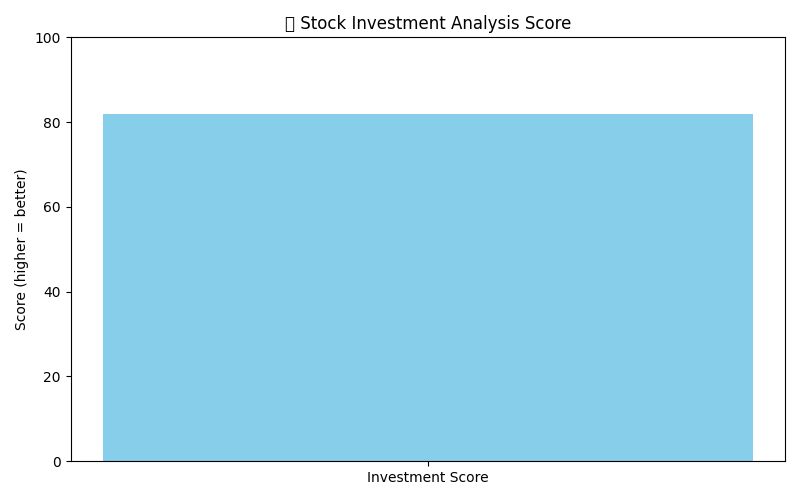


🔍 **Detailed Insights**
- **Company Overview**: Apple Inc. is a leading technology company that designs, manufactures, and markets smartphones (iPhone), personal computers (Mac), tablets (iPad), wearables and accessories. The company also provides various services including Apple Arcade, Apple Music, Apple TV+, and operates platforms like the App Store. With a market cap of $3.15 trillion, Apple is one of the world's most valuable companies.
- **Financial Health**: Apple demonstrates strong financial health with a solid balance sheet. The company has a trailing P/E ratio of 32.88, indicating premium valuation. Revenue for the trailing twelve months stands at $400.37 billion with net income of $97.29 billion. Apple maintains healthy cash reserves of $48.5 billion, though it carries some debt with a debt-to-equity ratio of 146.99%. The company generates substantial free cash flow of $97.25 billion annually, supporting its dividend yield of 0.52%.
- **Growth Potential**: Apple shows mixe

In [71]:
analyze_stock('AAPL')   # 🍏 Feel free to try other symbols here!


=== 🏦 Starting analysis for: MSFT ===
Searching WaterCrawl for 📈 stock: MSFT on https://finance.yahoo.com
🔗 Found 4 relevant pages!
 📚 Found pages: ['https://finance.yahoo.com/quote/MSFT/', 'https://finance.yahoo.com/quote/MSFT/analysis/', 'https://uk.finance.yahoo.com/quote/MSFT/', 'https://ca.finance.yahoo.com/quote/MSFT/']
 📚 Scraping page: https://finance.yahoo.com/quote/MSFT/
 📚 Scraping page: https://finance.yahoo.com/quote/MSFT/analysis/
 📚 Scraping page: https://uk.finance.yahoo.com/quote/MSFT/
 📚 Scraping page: https://ca.finance.yahoo.com/quote/MSFT/


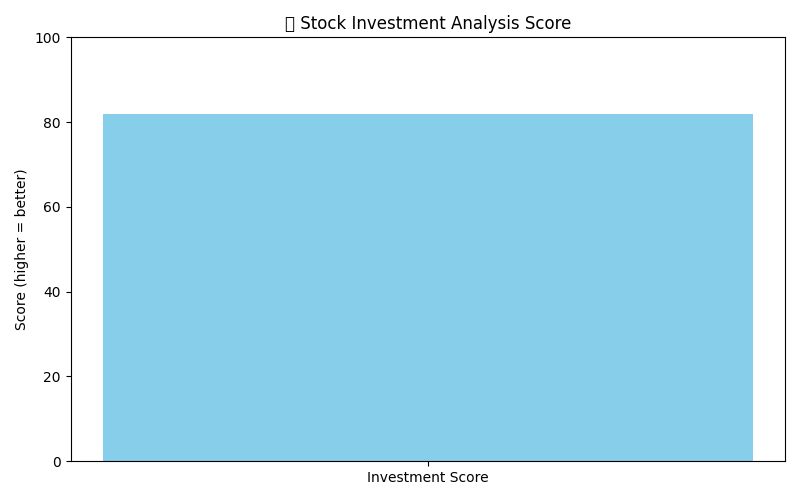


🔍 **Detailed Insights**
- **Company Overview**: Microsoft Corporation is a global technology leader that develops and supports software, services, devices, and solutions worldwide. Founded in 1975 and headquartered in Redmond, Washington, the company operates through three main segments: Productivity and Business Processes (including Office 365, LinkedIn, and Dynamics), Intelligent Cloud (Azure, server products, and enterprise services), and More Personal Computing (Windows, devices, gaming, and search advertising).
- **Financial Health**: Microsoft demonstrates exceptional financial strength with a market capitalization of $3.34 trillion, making it one of the world's most valuable companies. The company maintains robust profitability with a 35.79% profit margin and $96.64 billion in net income. With $79.62 billion in cash reserves, a manageable debt-to-equity ratio of 32.63%, and strong free cash flow of $54.82 billion, Microsoft has ample resources to fund operations, investments, a

In [72]:
analyze_stock('MSFT')   # 🍏 Feel free to try other symbols here!

---
## 7. 💡 Best Practices & Tips

✔️ **Rate Limiting**: WaterCrawl is smart, but don't hammer sites! Consider sleep delays for big scrapes.

✔️ **Error Handling**: Always check responses, catch exceptions, and log unexpected content.

✔️ **Data Quality**: Validate what you scrape, and if investing, always double-check data from multiple sources.

✔️ **Performance**: For mass crawling, consider async techniques or chunked batches.

_**Note:** This demo is for educational purposes. Do not use AI output as investment advice!_


---
## 8. 🌱 Next Steps & Remix Ideas

🎯 Try analyzing more tickers or sectors

📅 Add historical trends & time series charts

🔄 Incorporate technical indicators

🔥 Build a portfolio analyzer by looping over a stock list

_Happy Crawling & Analyzing!_
